In [1]:
import pandas as pd
import seaborn as sns
from pandas.api.types import is_numeric_dtype
sns.set_style('darkgrid')
sns.set_context('talk')

In [2]:
df = pd.read_csv('traferrstats/stats.tsv', sep='\t', header=None, names=['index','segments','chars','docs'])

df['index'] = df['index'].str.split(',')

for c,i in zip(['crawl','lang','textlen'], [0,1,-1]):
    df[c] = df['index'].str[i]

df['error'] = df['index'].str[2:-1].str.join(',')
df.drop(columns='index', inplace=True)
df.head()

,segments,chars,docs,crawl,lang,textlen,error
0,350,8027,7.0,CC-MAIN-2013-20_partial,ace_Arab,>1,OK
1,50605,1103948,2693.0,CC-MAIN-2013-20_partial,ace_Latn,>1,OK
2,63,2161,8.0,CC-MAIN-2013-20_partial,ace_Latn,>1,['UnicodeDecodeError']
3,222535,8129823,13265.0,CC-MAIN-2013-20_partial,afr_Latn,>1,OK
4,101,1984,18.0,CC-MAIN-2013-20_partial,afr_Latn,>1,['UnicodeDecodeError']


### Prettify types of text extraction result

In [3]:
df.error.value_counts()

error
OK                                                                                                                                                                                                                                                                                                                         23093
['UnicodeDecodeError']                                                                                                                                                                                                                                                                                                     18451
['Traceback (most recent call last):\n  File "/pfs/lustrep3/scratch/project_465000498/two/code/warc2text-runner/venv/lib/python3.10/site-packages/warc2text_runner/two/trafilatura/traf.py", line 53, in traf\n    raise ValueError("Could not parse HTML")\nValueError: Could not parse HTML\n']                            103
['Trafilatura timed out: 0.5s']

In [4]:
from ast import literal_eval
def prettify_error(e):
    return 'Timeout' if e.startswith('Trafilatura timed out') else 'HTML parsing error' if 'Could not parse HTML' in e else e

def prettify_errors(l):
    return prettify_error(l[0]) if len(l)==1 else ','.join(prettify_error(e) for e in l)
        
df.error = df.error.apply(lambda s: prettify_errors(literal_eval(s)) if s.startswith('[') else s)
df.error.value_counts()

error
OK                                       23093
UnicodeDecodeError                       18451
HTML parsing error                         103
Timeout                                    103
UnicodeDecodeError,HTML parsing error      103
UnicodeDecodeError,Timeout                 103
Name: count, dtype: int64

### Stage2 errors and proportions

In [5]:
sdf = df.groupby('error').sum(numeric_only=True).astype(float).sort_values(by='docs', ascending=False)
sdf

,segments,chars,docs
error,,,
OK,2.193735e+12,1.443365e+14,1.019288e+11
HTML parsing error,3.053370e+09,0.000000e+00,3.053370e+09
UnicodeDecodeError,2.512878e+10,1.769207e+12,8.451399e+08
Timeout,3.417328e+08,0.000000e+00,3.417328e+08
"UnicodeDecodeError,Timeout",6.110628e+06,0.000000e+00,6.110628e+06
"UnicodeDecodeError,HTML parsing error",2.578599e+06,0.000000e+00,2.578599e+06


In [6]:
sdf.apply(lambda r: r/r.sum())

,segments,chars,docs
error,,,
OK,0.987161,0.987891,0.959983
HTML parsing error,0.001374,0.000000,0.028757
UnicodeDecodeError,0.011308,0.012109,0.007960
Timeout,0.000154,0.000000,0.003218
"UnicodeDecodeError,Timeout",0.000003,0.000000,0.000058
"UnicodeDecodeError,HTML parsing error",0.000001,0.000000,0.000024


96% of docs are processed w/o errors; 3% of docs had HTML parsing errors with no texts extracted; <1% of docs had other errors

In [7]:
sdf = df.groupby('textlen').sum(numeric_only=True).astype(float)
sdf.apply(lambda r: r/r.sum())

,segments,chars,docs
textlen,,,
0,0.010245,0.000000e+00,0.214427
1,0.000013,2.028908e-07,0.000279
>1,0.989742,9.999998e-01,0.785293


In [8]:
sdf = df.groupby(['textlen','error']).sum(numeric_only=True).astype(float)
sdf.apply(lambda r: r/r.sum())

segments         chars  \
textlen error                                                               
0       HTML parsing error                     1.373989e-03  0.000000e+00   
        OK                                     8.635160e-03  0.000000e+00   
        Timeout                                1.537766e-04  0.000000e+00   
        UnicodeDecodeError                     7.829942e-05  0.000000e+00   
        UnicodeDecodeError,HTML parsing error  1.160346e-06  0.000000e+00   
        UnicodeDecodeError,Timeout             2.749727e-06  0.000000e+00   
1       OK                                     1.317795e-05  2.004365e-07   
        UnicodeDecodeError                     1.613577e-07  2.454250e-09   
>1      OK                                     9.785123e-01  9.878907e-01   
        UnicodeDecodeError                     1.122926e-02  1.210908e-02   

                                                   docs  
textlen error                                            
0       HTML parsing error                     0.028757  
        OK                                     0.180731  
        Timeout                                0.003218  
        UnicodeDecodeError                     0.001639  
        UnicodeDecodeError,HTML parsing error  0.000024  
        UnicodeDecodeError,Timeout             0.000058  
1       OK                                     0.000276  
        UnicodeDecodeError                     0.000003  
>1      OK                                     0.778976  
        UnicodeDecodeError                     0.006318

From 21% of docs with empty text extracted, 18% of docs have no extraction errors

In [9]:
df['restype'] = df.textlen + ':' + df.error
df.drop(columns=['textlen','error'], inplace=True)

### Do proportions of errors depend on the crawl?

In [63]:
def plot_props(df, catcol, stylecol=None, savefig=None, height=5, aspect=1.0):
    total = df.groupby('restype').sum(numeric_only=True).reset_index()
    total[catcol], total[stylecol] = '_TOTAL_', '_TOTAL_'
    df = pd.concat([total, df], ignore_index=True)
    sdf = df.groupby([catcol,'restype'] + ([stylecol] if stylecol else []), sort=False).sum(numeric_only=True).reset_index()    
    sdf.docs = sdf.groupby(catcol).docs.transform(lambda s: s/s.sum())

    g = sns.relplot(data=sdf, x='docs', y=catcol, hue='restype', style=stylecol, 
                    height=height, aspect=aspect)
    g.set(xticks=[0.05*i for i in range(21)])
    if savefig:
        g.savefig(savefig)

/home/nikolare/anaconda3/envs/jupyterai/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/nikolare/anaconda3/envs/jupyterai/lib/python3.10/site-packages/seaborn/axisgrid.py:181: UserWarning: The label '_TOTAL_' of <matplotlib.collections.PathCollection object at 0x7f667ee68700> starts with '_'. It is thus excluded from the legend.
  figlegend = self._figure.legend(handles, labels, **kwargs)


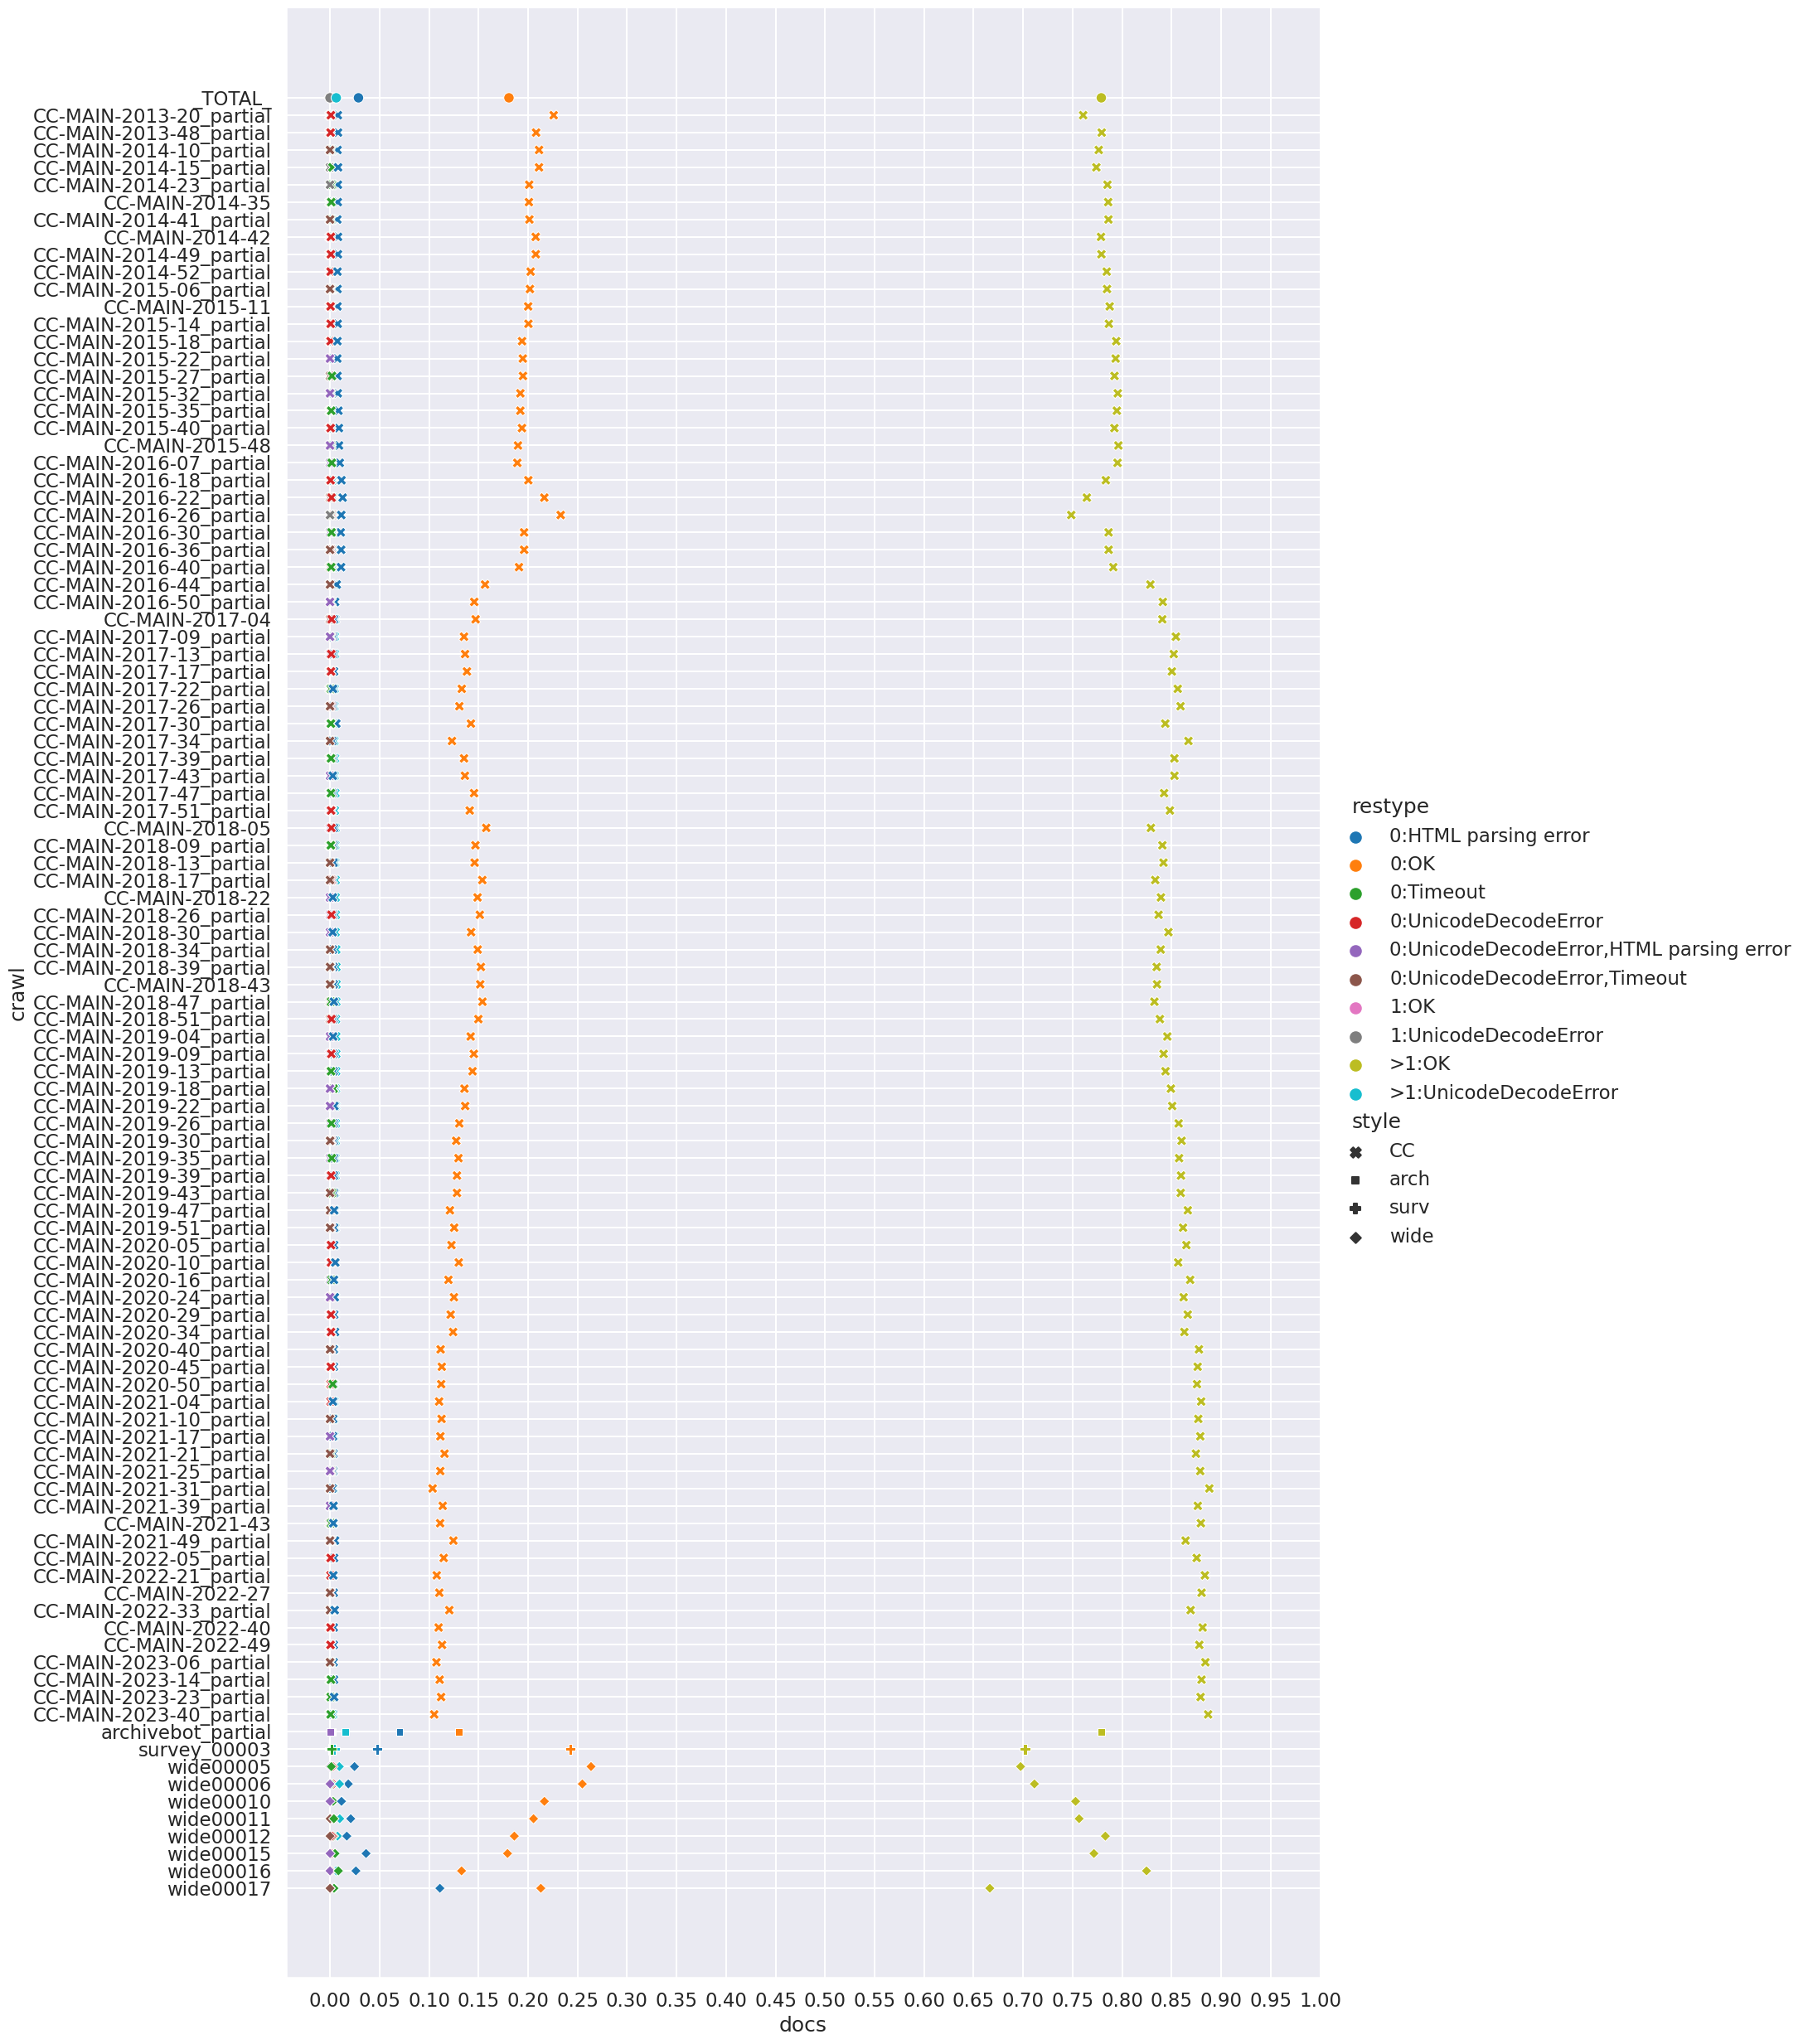

In [79]:
df['style'] = df.crawl.apply(lambda c: c[:2] if c.startswith('CC') else c[:4])
df = df.sort_values(by='crawl')
plot_props(df, 'crawl', stylecol='style', savefig='traferrsVScrawl.pdf', height=25, aspect=0.7)

CC crawls: <1% of documents with errors
CC before 2016: 77-80% of non-empty texts w/o errors; 18-22% of empty texts extracted w/o errors;
CC 2016: propotions jumps (within 5% of the original ones)
CC since 2017: the proportion of non-empty texts is growing up to 86-88% by 2020-2023, 
    the proportion of empty texts extracted w/o errors is decreasing to 11-13%
    
IA crawls: 
    HTML parsing errors: 2-4% for most wide crawls, 11% for wide17, 5% for survey, 7% for archivebot
    UnicodeDecodeError with non-empty text extracted: ~1-1.5%
    non-empty texts w/o errors: 70-80% for most wide crawls, ~67% for wide17, 70% for survey, 78% for archivebot
    empty texts w/o errors: 17-27% for most wide crawls; 13% for wide16 and archviebot, 25% for survey

### Do proportions of errors depend on the lang?

/home/nikolare/anaconda3/envs/jupyterai/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


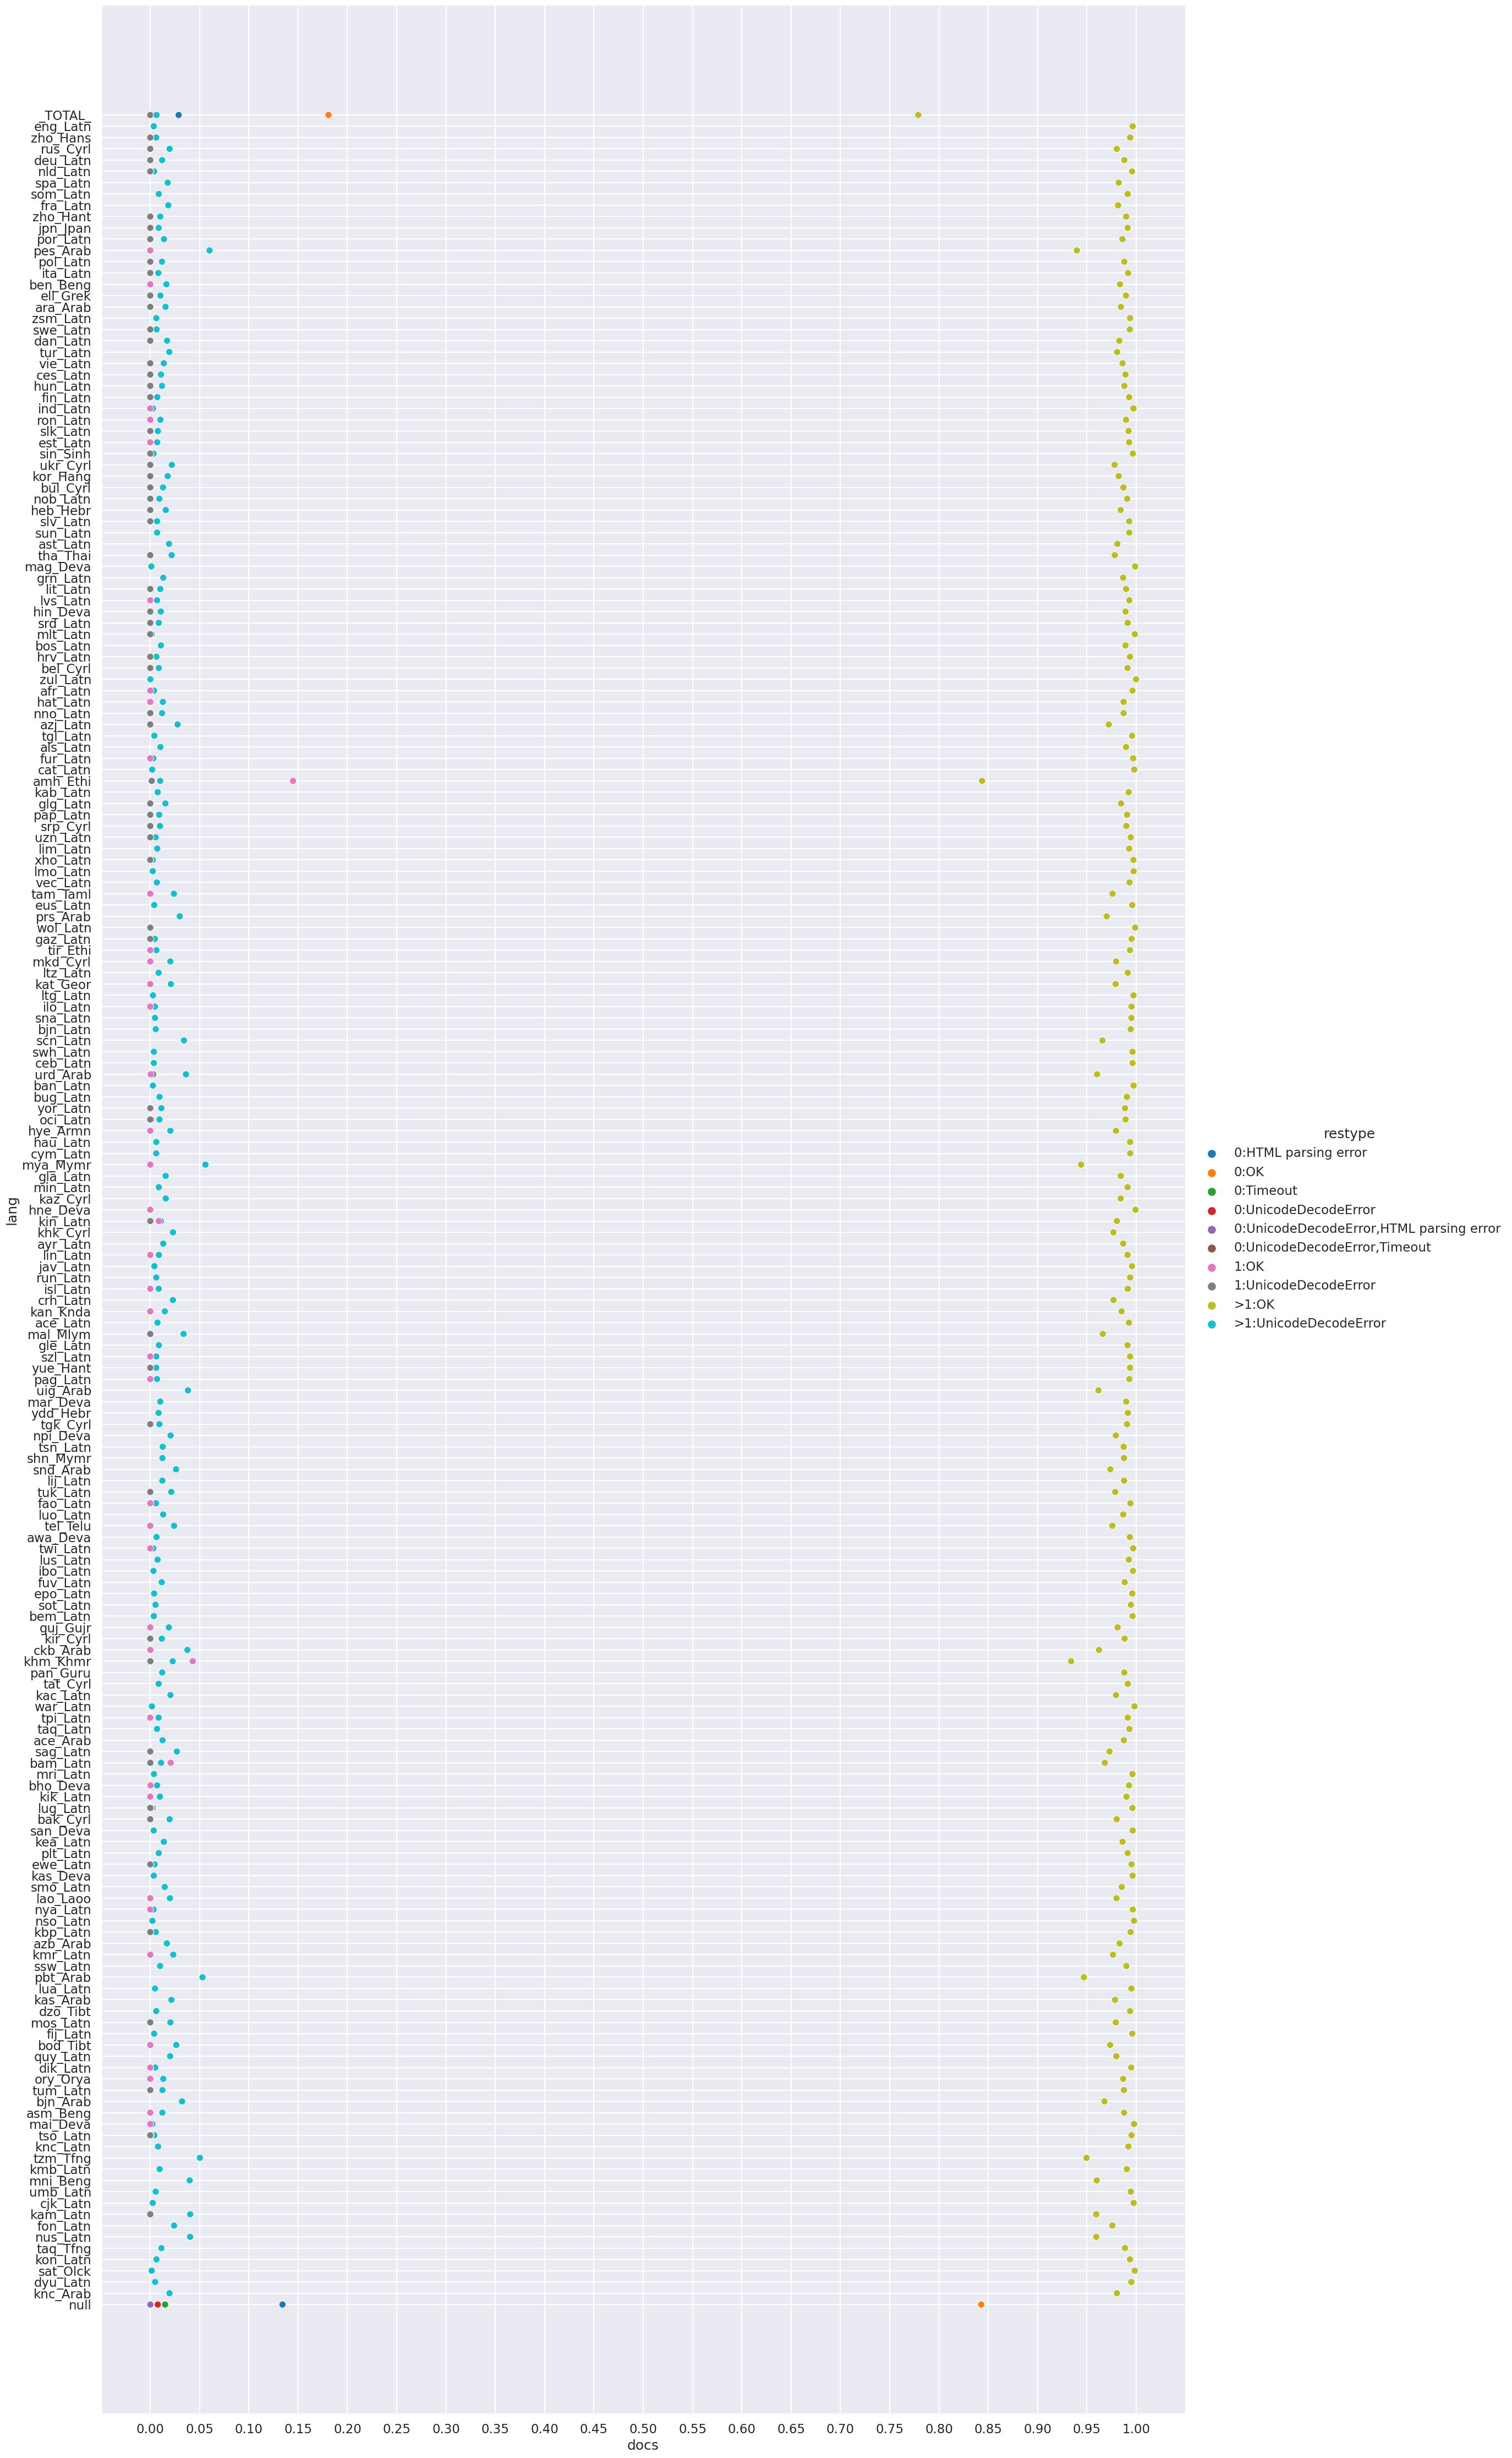

In [78]:

df = df.sort_values(by='chars', ascending=False)
plot_props(df, 'lang', savefig='traferrsVSlang.pdf', height=45, aspect=0.5)

For most languages >95% of documents were processed w/o errors and have >1 character extracted. 1-4% of docs with some UnicodeDecodeErrors.

Exceptions:
pes_Arab, mya_Mymr, pbt_Arab, tzm_Tfng: 5-6% of UnicodeDecodeErrors, 
amh_Ethi: 15% of docs with 1 character and no errors
khm_Khmr: 5% of docs with 1 character and no errors